x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


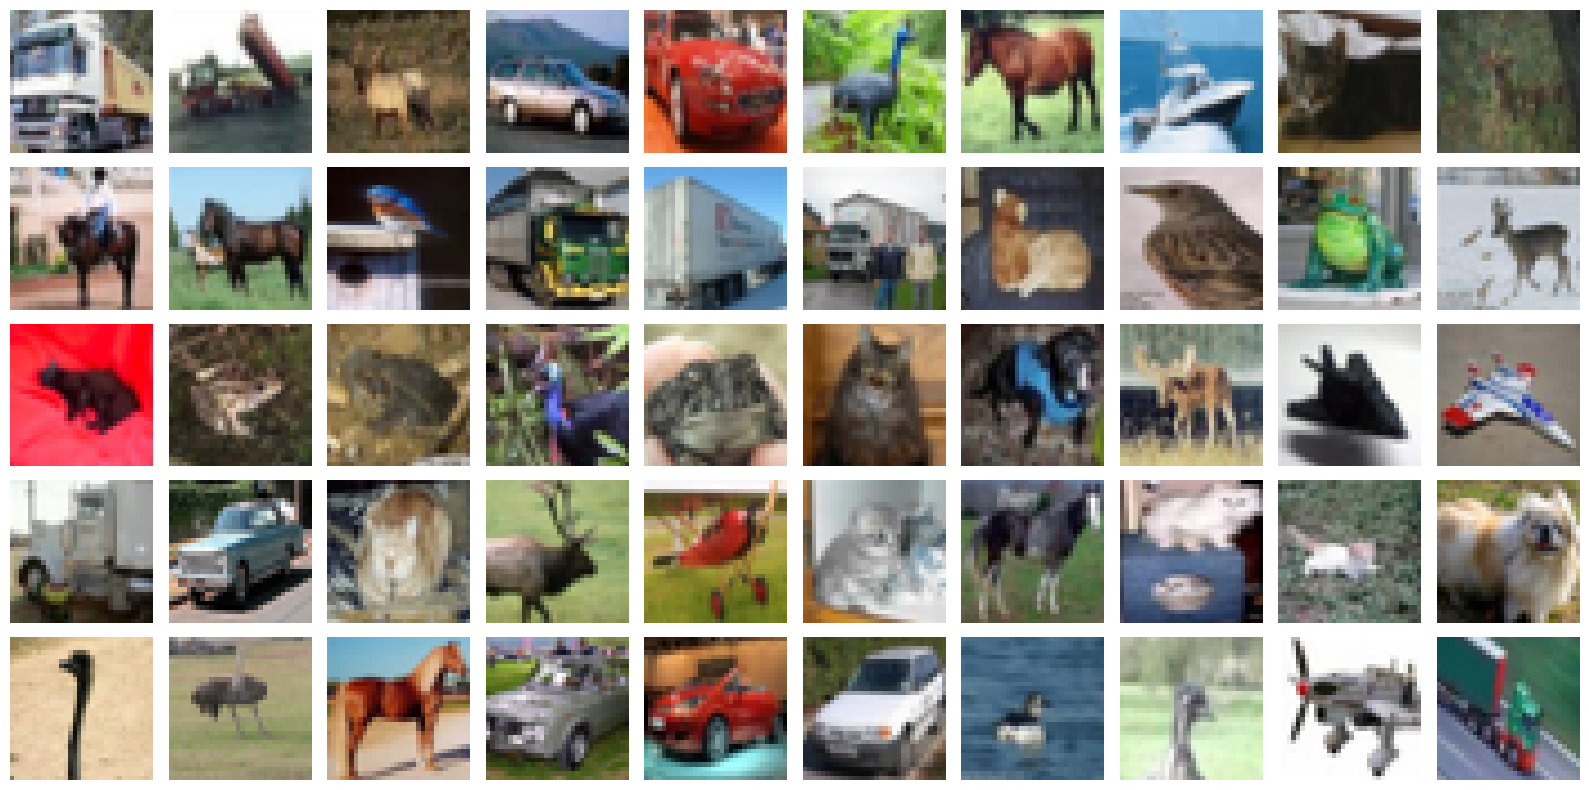



INFO: Training epoch number: 1 with learning rate: 0.0010000000474974513

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1619 - loss: 2.2524
Epoch 1: val_accuracy improved from -inf to 0.22780, saving model to best_model.keras
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 94s 51ms/step - accuracy: 0.1619 - loss: 2.2523 - val_accuracy: 0.2278 - val_loss: 1.8868 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy after epoch 1: 22.78%


INFO: Training epoch number: 2 with learning rate: 0.0010000000474974513

1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1917 - loss: 1.9528
Epoch 1: val_accuracy did not improve from 0.22780
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.1917 - loss: 1.9528 - val_accuracy: 0.2130 - val_loss: 2.0051 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
Validation Accuracy after epoch 2: 21.30%


INFO: Training epoch number: 3 with learning rate: 0.00100000

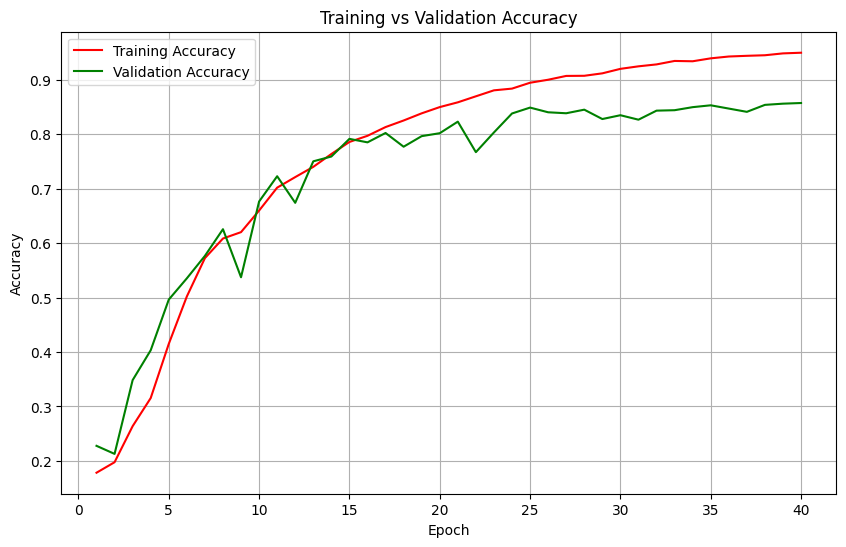

Test Loss: 0.6997
Test Accuracy: 84.51%


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K

from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Display sample images
def display_sample_images(x_train, columns=10, rows=5):
    fig = plt.figure(figsize=(16, 8))
    for i in range(1, columns * rows + 1):
        img = x_train[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(x_train)

# Preprocess data
X_train = x_train.astype('float32') / 255.0
X_test = x_test.astype('float32') / 255.0

# One-hot encode labels
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

# Build the VGG16-like model
def build_vgg16_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = build_vgg16_model()

# Define optimizers with updated parameter names
sgd = SGD(learning_rate=1e-3, decay=5e-4, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3)

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

# **Modified Line**: Changed 'best_model.h5' to 'best_model.keras'
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

callbacks_list = [reduce_lr, early_stopping, checkpoint]

# Training parameters
min_epochs = 40  # Minimum number of epochs before considering stopping
count = 1
flag = 1
val_acc = []
train_acc = []

while flag == 1:
    current_lr = K.get_value(model.optimizer.learning_rate)
    print(f"\n\nINFO: Training epoch number: {count} with learning rate: {current_lr}\n")

    history = model.fit(
        X_train, Y_train,
        batch_size=32,
        epochs=1,
        verbose=1,
        validation_split=0.1,
        callbacks=callbacks_list
    )

    # Append scalar values
    val_acc.append(history.history['val_accuracy'][0])
    train_acc.append(history.history['accuracy'][0])

    # Optional: Print current validation accuracy
    print(f"Validation Accuracy after epoch {count}: {val_acc[-1]*100:.2f}%")

    # Checking if another epoch needs to be run
    if count >= min_epochs:
        while True:
            inp = input("Type 'y' to run another epoch or 'n' to stop training: ").strip().lower()
            if inp == 'y':
                flag = 1
                break
            elif inp == 'n':
                flag = 0
                break
            else:
                print("Invalid input. Please enter 'y' or 'n'.")

    # Increasing the epoch number
    count += 1

# Plotting training and validation accuracy
def plot_accuracy(train_acc, val_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_acc)+1), train_acc, label='Training Accuracy', color='red')
    plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation Accuracy', color='green')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(train_acc, val_acc)

# Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Loss: {score[0]:.4f}")
print(f"Test Accuracy: {score[1]*100:.2f}%")
